In [1]:
# filter_normal: There appear to be two populations of people taking the dmv test. One population, A,
# has scores that are independent of duration, how long they take to finish the test. The other
# population, B, does better on the test the less time they take. A plot of the passing rate vs. 
# test duration shows a change point between 12 and 15 minutes. After 15 minutes the passing rate 
# is independent of duration after change point = [12.1, 15] min
# This study assumes that the population A is also taking the test before the changepoint. The # of 
# people in A who pass can be estimated from the number who failed and the A's passing rate. Subtracting
# this number from the whole population will give use the number of people in population B who passed.


In [2]:
import dmv_test_input as dti
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from xpassing_rate import passing_rate, duration_intervals

changept = 14.5

In [3]:
def get_log():
    df = dti.read_dmv_log(case=2)
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    df["passed"]  = (df.Result=="P")
    df["difference"] = df.elapsed - df.duration
    # Ignore data with unusual and incorrect duration:
    # - Drop rows when duration <= 0 because that's not possible
    ## - Drop rows when duration > 40 (the 83rd percentile). df.duration.quantile(.8315) = 40
    # - Drop rows when duration > 120 (the 99rd percentile). df.duration.quantile(.99) = 120
    #   This is a point when the variance in the data begins to grow dramatically
    # - Drop when elapsed>60. Sometimes there's a huge difference from duration, hours even.
    len_before = len(df)
    df = df[ (df.duration > 0) & (df.duration <= 120) & (df.elapsed > 0) & (df.elapsed < 120)].reset_index()
    len_after  = len(df)
    print(f"{len_before - len_after} events dropped with unusual duration.")
    
    return df


In [4]:
df = get_log()
limits = duration_intervals(lo=5, hi=40., inc=.05)
print(f'The change point is {changept} minutes.')

Original length of sample data is 152519
2415 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1056 tests
1893 events dropped with unusual duration.
The change point is 14.5 minutes.


In [5]:
col = ["ExamineeId", "TestStartDateTime", "TestEndDateTime", 
       "Result", "TotalScore", "duration", "elapsed", "difference"]


In [6]:
test_times = ["duration", "elapsed"]
pf = passing_rate(df, test_times, limits)


In [7]:
for x in list(zip(1 - pf.duration_rate, pf.duration_rate))[:10]:
    print(x)

pf['failing_rate'] = 1 - pf.duration_rate

(0.0847457627118644, 0.9152542372881356)
(0.046511627906976716, 0.9534883720930233)
(0.020000000000000018, 0.98)
(0.03703703703703709, 0.9629629629629629)
(0.07894736842105265, 0.9210526315789473)
(0.038461538461538436, 0.9615384615384616)
(0.061224489795918324, 0.9387755102040817)
(0.0357142857142857, 0.9642857142857143)
(0.01851851851851849, 0.9814814814814815)
(0.06818181818181823, 0.9318181818181818)


In [8]:
pd.DataFrame(limits).describe()


,0,1
count,700.000000,700.000000
mean,22.475000,22.525000
std,10.110844,10.110844
min,5.000000,5.050000
25%,13.737500,13.787500
50%,22.475000,22.525000
75%,31.212500,31.262500
max,39.950000,40.000000


In [9]:
a_duration_rate = np.array(pf.duration_rate)
hist = np.histogram(a_duration_rate, bins=len(a_duration_rate))

In [10]:
hist = np.histogram(pf.duration_rate)



<IPython.core.display.Javascript object>


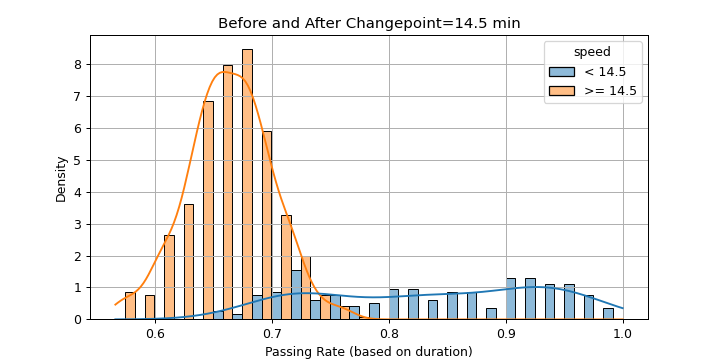

In [11]:
def draw_passing_rate_before_and_after_changept(pf, changept=changept, duration_time='duration'):
    # Histogram of passing rate before and after changept
    duration_rate = f'{duration_time}_rate'
    pf["speed"] = pf.duration.apply(lambda x: f"< {changept}" if x<changept else f">= {changept}")

    fig, ax = plt.subplots(figsize=(8, 4))
    g = sns.histplot(data=pf, x=duration_rate, hue="speed", kde=True, multiple="dodge", stat='density')

    g.set_xlabel(f'Passing Rate (based on {duration_time})')
    g.set_title(f"Before and After Changepoint={changept} min")

    plt.subplots_adjust(top=0.90)
    plt.grid()
    plt.show()
    
draw_passing_rate_before_and_after_changept(pf, changept=changept, duration_time='duration')

<IPython.core.display.Javascript object>


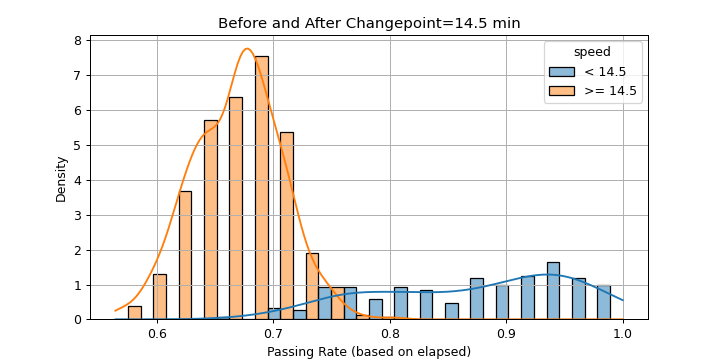

In [12]:
draw_passing_rate_before_and_after_changept(pf, changept=changept, duration_time='elapsed')

<IPython.core.display.Javascript object>


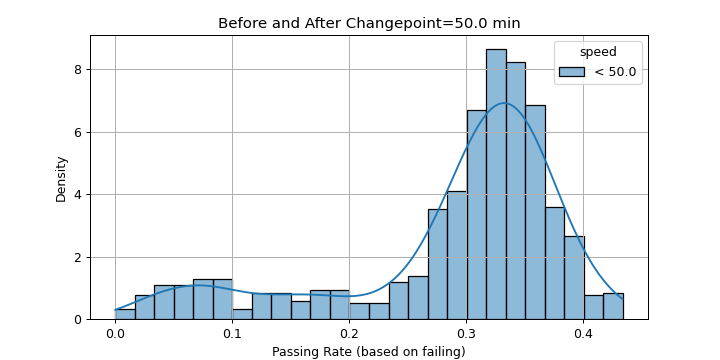

In [13]:
draw_passing_rate_before_and_after_changept(pf, changept=50., duration_time='failing')

In [14]:
# fig, ax = plt.subplots(figsize=(8,4))
# plt.hist(pf.duration_rate)
# plt.show()

# type(g)


# g.lines[0].get_xdata(orig=True)



# g.lines[0].get_ydata(orig=True)



# fig, ax = plt.subplots(figsize=(8,4))
# plt.plot(g.lines[0].get_xdata(orig=True), g.lines[0].get_ydata(orig=True))
# plt.plot(g.lines[1].get_xdata(orig=True), g.lines[1].get_ydata(orig=True))
# plt.show()

In [15]:
df[(df.duration < 40) & (df.duration>0) & (df.difference > 0) & (df.elapsed<50)][col].difference.describe()

count    122516.000000
mean          2.272842
std           2.546261
min           0.000550
25%           1.139450
50%           1.483942
75%           2.157629
max          44.898067
Name: difference, dtype: float64

In [16]:
pf.duration_rate.describe()

count    700.000000
mean       0.711273
std        0.097073
min        0.566372
25%        0.650206
50%        0.680308
75%        0.726172
max        1.000000
Name: duration_rate, dtype: float64

mean=0.7112725845849703 std=0.09707306572518425


<IPython.core.display.Javascript object>


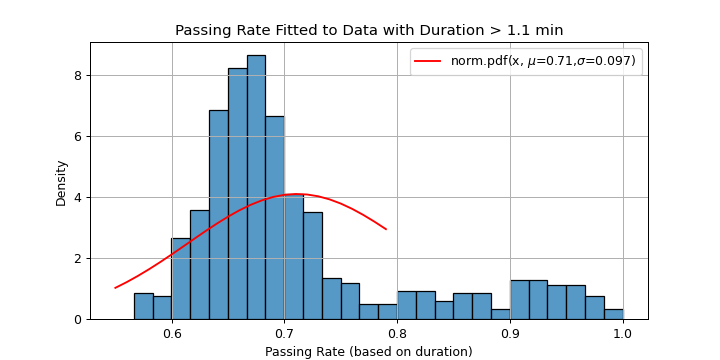

In [17]:
def draw_fitted_passing_rate(pf, changept=changept):
    # Draw graph of the density (probability) of passing rates 
    # for duration greater than a changepoint
    from matplotlib.lines import Line2D # For points and lines
    from matplotlib.legend import Legend
    from scipy.stats import norm
    
    # Find the mean and stdev of passing rate for higher test duration
    pflong = pf[pf.duration>changept].reset_index()
    mean = pflong.duration_rate.mean()
    std  = pflong.duration_rate.std()
    print(f"{mean=} {std=}")

    # Calc normal probability distribution from mean and stdev
    x = np.arange(.55, .8, .01)
    y = norm.pdf(x, mean, std)

    # Plot them both
    fig, ax = plt.subplots(figsize=(8,4))
    g=sns.histplot(pflong, x="duration_rate", stat='density', ax=ax)
    line_label = f'norm.pdf(x, $\\mu$={mean:.2f},$\\sigma$={std:.3f})'
    line = g.plot(x, y, color='red', label=line_label)
    g.set_xlabel('Passing Rate (based on duration)')
    g.set_title(f'Passing Rate Fitted to Data with Duration > {changept} min')

    # Draw a legend for the added line 
    # See: Guangyuan (Frank) Li, Towards Data Science

    ax.grid()
    ax.legend(handles=[line[0]])
    plt.show()
    
draw_fitted_passing_rate(pf, changept=1.1)

mean=0.6646364695395724 std=0.037353813094953225


<IPython.core.display.Javascript object>


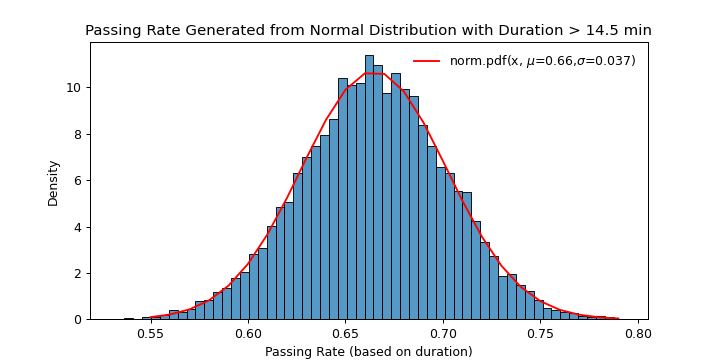

In [24]:
def plot_generated_passing_rate(pf, changept=changept):
    # Draw graph of the density (probability) of passing rates 
    # for duration greater than a changepoint
    from matplotlib.lines import Line2D # For points and lines
    from matplotlib.legend import Legend
    from scipy.stats import norm
    
    # Find the mean and stdev of passing rate for higher test duration
    pflong = pf[pf.duration>21.1].reset_index()
    mean = pflong.duration_rate.mean()
    std  = pflong.duration_rate.std()
    print(f"{mean=} {std=}")

    # Calc normal probability distribution from mean and stdev
    x = np.arange(.55, .8, .01)
    y = norm.pdf(x, mean, std)

    #generate a random sample from implied normal distribution
    z = pd.DataFrame(np.random.normal(loc=mean, scale=std, size=10000), columns=['sample'])

    # Plot them both
    fig, ax = plt.subplots(figsize=(8,4))
    g=sns.histplot(z, x="sample", stat='density', ax=ax)
    line = g.plot(x, y, color='red')
    g.set_xlabel('Passing Rate (based on duration)')
    g.set_title(f'Passing Rate Generated from Normal Distribution with Duration > {changept} min')

    # Draw a legend for the added line (one patch is needed for every line)
    # Method: https://stackoverflow.com/questions/42767489/add-legend-to-seaborn-point-plo
    # We will need to access some of these matplotlib classes directly
#     patch = [ Line2D([0], [0], color='red') ]
#     line_label = f'norm.pdf(x, $\\mu$={mean:.2f},$\\sigma$={std:.3f})'
#     leg = Legend(ax, patch, labels=[line_label], frameon=False, loc='upper right')
#     ax.add_artist(leg)

    # Draw a legend for the added line 
    line_label = f'norm.pdf(x, $\\mu$={mean:.2f},$\\sigma$={std:.3f})'
    ax.legend(handles=[line[0]], labels=[line_label], frameon=False)

    plt.show()
    
plot_generated_passing_rate(pf, changept=changept)

In [19]:
pf


,lo,hi,duration,duration_rate,ncount,pcount,elapsed_rate,failing_rate,speed
0,5.00,5.05,5.00,0.915254,32,31,0.968750,0.084746,< 50.0
1,5.05,5.10,5.05,0.953488,37,37,1.000000,0.046512,< 50.0
2,5.10,5.15,5.10,0.980000,43,43,1.000000,0.020000,< 50.0
3,5.15,5.20,5.15,0.962963,38,37,0.973684,0.037037,< 50.0
4,5.20,5.25,5.20,0.921053,32,32,1.000000,0.078947,< 50.0
...,...,...,...,...,...,...,...,...,...
695,39.75,39.80,39.75,0.640351,98,67,0.683673,0.359649,< 50.0
696,39.80,39.85,39.80,0.678571,96,60,0.625000,0.321429,< 50.0
697,39.85,39.90,39.85,0.609195,126,87,0.690476,0.390805,< 50.0
698,39.90,39.95,39.90,0.589474,103,65,0.631068,0.410526,< 50.0


In [20]:
pf["hiperformers"] = pf.ncount - pf.ncount*pf.duration_rate


<IPython.core.display.Javascript object>


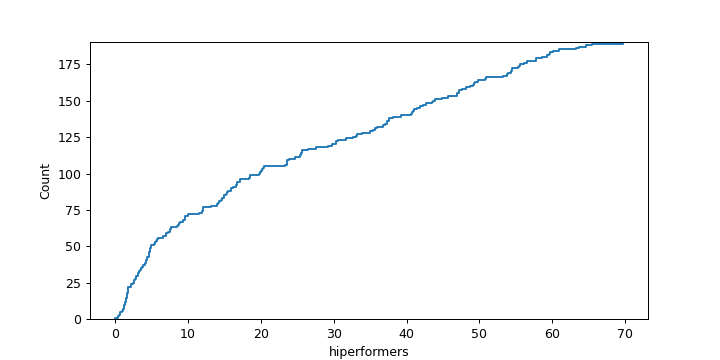

In [21]:
# Estimate the number of high performers by subtracting the amount 
# predicted by using the passing rate of all users after the changepoint.
fig, ax = plt.subplots(figsize=(8,4))
# sns.histplot(data=pf[(pf.duration<changept) & (pf.duration>5.)], x='cheaters' ,kde=True, bins=20)
sns.ecdfplot(data=pf[(pf.duration<changept) & (pf.duration>5.)], x='hiperformers', stat='count')
plt.show()

<IPython.core.display.Javascript object>


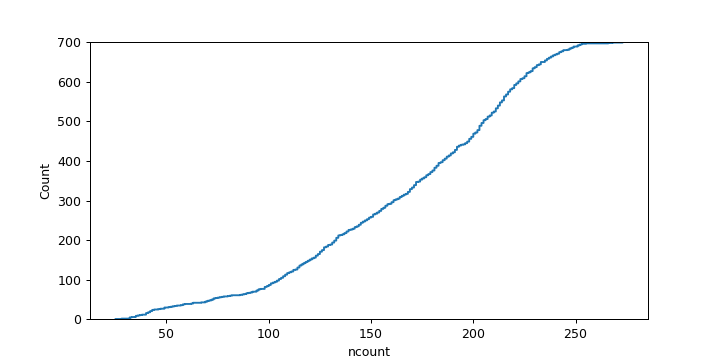

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
# sns.histplot(data=pf[(pf.duration<changept) & (pf.duration>5.)], x='cheaters' ,kde=True, bins=20)
# sns.ecdfplot(data=pf[(pf.duration<changept) & (pf.duration>5.)], x='hiperformance')
sns.ecdfplot(data=pf, x='ncount', stat='count')
plt.show()

In [23]:
tab=['duration', 'ncount', 'pcount', 'hiperformers']
pf[tab]

,duration,ncount,pcount,hiperformers
0,5.00,32,31,2.711864
1,5.05,37,37,1.720930
2,5.10,43,43,0.860000
3,5.15,38,37,1.407407
4,5.20,32,32,2.526316
...,...,...,...,...
695,39.75,98,67,35.245614
696,39.80,96,60,30.857143
697,39.85,126,87,49.241379
698,39.90,103,65,42.284211
